<a href="https://colab.research.google.com/github/enwachukwu/abc/blob/main/Transfer_Learning_for_image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19  # Import the VGG19 model

In [ ]:
image_size = 224
batch_size = 16
EPOCHS = 2
num_classes = 2

train_data_dir = '/content/drive/MyDrive/catsvsdogs/train'
test_data_dir = '/content/drive/MyDrive/catsvsdogs/test'

In [ ]:
# Create an instance of the ImageDataGenerator class with various transformations parameters.
datagen = ImageDataGenerator(
    horizontal_flip=True,  # Randomly flip inputs horizontally for data augmentation.
    vertical_flip=True,  # Randomly flip inputs vertically for data augmentation.
    rotation_range=40,  # Randomly rotate images in the range (in degrees, 0-180), 40 degrees here, for data augmentation.
    width_shift_range=0.1,  # Randomly translate pictures horizontally (fraction of total width) for data augmentation.
    height_shift_range=0.1,  # Randomly translate pictures vertically (fraction of total height) for data augmentation.
    zoom_range=.1,  # Randomly zoom inside pictures for data augmentation (10% zoom in or out).
    rescale=1/255,  # Rescale the image by normalizing it. Normalization helps in faster convergence.
    fill_mode='nearest',  # Points outside the boundaries of the input are filled according to the given mode ('nearest' uses the value of the nearest pixel).
    shear_range=0.1,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees) for data augmentation.
    brightness_range=[0.5, 1.5],  # Range for picking a brightness shift value from. Here it's between 50% (darker) and 150% (brighter).
    validation_split=0.2  # Reserve 10% of images for validation. This will split your data into training and validation.
)

In [ ]:
# 'datagen' is an instance of 'ImageDataGenerator' which helps with real-time data augmentation.
# Here, 'flow_from_directory' is used to generate batches of augmented/normalized data from the directory
# specified by 'train_data_dir'. This data will be looped over in batches during training.
train_generator = datagen.flow_from_directory(
        train_data_dir,  # Directory where the training data is located
        target_size = (image_size, image_size),  # Dimensions to which all images found will be resized
        batch_size=batch_size,  # Size of the batches of data
        class_mode='categorical',  # Because we use categorical_crossentropy loss, we need categorical labels
        subset='training')  # Specifies this is the training subset of data (in conjunction with 'validation_split' in 'datagen')


# Similar to the training generator, but this time the data is pulled from the same directory and specified for validation.
# No data augmentation is applied to validation data, but it should be normalized like the training data.
validation_generator = datagen.flow_from_directory(
        train_data_dir,  # Directory where the training data is located (validation data is often in the same place)
        target_size = (image_size, image_size),  # Dimensions to which all images found will be resized
        batch_size=batch_size,  # Size of the batches of data
        class_mode='categorical',  # Because we use categorical_crossentropy loss, we need categorical labels
        subset='validation',  # Specifies this is the validation subset of data (in conjunction with 'validation_split' in 'datagen')
        shuffle=False)  # Data will be read in order, without shuffling


# 'test_datagen' is another instance of 'ImageDataGenerator' for the test set, but only rescaling is applied.
# No data augmentation is used here because we want to evaluate the model on the original test data, not augmented data.
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescales the pixel values to the range [0, 1]

# Similar to 'train_generator' and 'validation_generator', but for the test set.
# Reads the test data from 'test_data_dir', applies rescaling, and generates batches of test data.
test_generator = test_datagen.flow_from_directory(
        test_data_dir,  # Directory where the test data is located
        target_size=(image_size,image_size),  # Dimensions to which all images found will be resized
        batch_size=batch_size,  # Size of the batches of data
        class_mode='categorical',  # Because we use categorical_crossentropy loss, we need categorical labels
        shuffle=False)

Found 2338 images belonging to 2 classes.
Found 584 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [ ]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
import efficientnet.keras as efn
# loading B4 without the final layer, we will change it
pretrained_model = efn.EfficientNetB4(include_top=False, input_shape=(224,224,3), pooling='avg', weights='imagenet')

x = pretrained_model.output
x = Flatten()(x)

predictions = Dense(2, activation="softmax")(x)
model = Model(inputs=pretrained_model.input, outputs=predictions )

71892840/71892840 [==============================] - 1s 0us/step


In [ ]:
# for layer in model.layers:
#     layer.trainable = False

In [ ]:
# # Let's print our layers
# for (i,layer) in enumerate(model.layers):
#     print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

In [ ]:
# x = Flatten()(x)
# x = BatchNormalization()(x)
# x = LeakyReLU()(x)
# x = Dense(2048, activation="relu")(x)
# x = BatchNormalization()(x)
# x = LeakyReLU()(x)
# x = Dense(1024, activation="relu")(x)
# x = BatchNormalization()(x)
# x = LeakyReLU()(x)

In [ ]:
print(model.summary())

In [ ]:
# Define a custom loss function for your model.
# In this case, it's categorical cross-entropy with label smoothing.
# Label smoothing is a regularization technique that prevents overfitting by slightly changing the true labels.
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

# Compile the model with the Adam optimizer and a learning rate of 0.0001.
# The loss function is the custom function defined above, and the model will also track accuracy as a performance metric.
model.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics=['accuracy'])

# Calculate the number of steps per epoch for training and validation.
# This is done by dividing the total number of samples by the batch size for each generator.
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

# Define a callback to reduce the learning rate if the validation accuracy plateaus.
# The learning rate will be reduced by multiplying it by a factor of 0.2 if the accuracy does not improve after 2 epochs.
# The reduction is subject to certain constraints to prevent it from decreasing below a minimum threshold.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

# Define a callback for early stopping to prevent overfitting.
# Training will stop if the validation accuracy does not improve by at least 0.0001 for 20 consecutive epochs.
# If training is halted, the model will revert to the weights of the epoch with the best observed validation accuracy.
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 20,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

# Define a callback for model checkpoints to save the model architecture and weights.
# This callback saves the model after every epoch where the validation accuracy improves.
# Only the best performing model will be saved, and it will be stored in the file 'model.h5'.
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = False,
                                                  mode = 'max')

# Group the callbacks into a list that can be passed to the model training function.
callbacks = [earlystopping, reduce_lr, checkpointer]

In [ ]:
history= model.fit(train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = validation_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

Epoch 1/2
146/146 [==============================] - ETA: 0s - loss: 0.3942 - accuracy: 0.8790
Epoch 1: val_accuracy improved from -inf to 0.95833, saving model to model
146/146 [==============================] - 1266s 8s/step - loss: 0.3942 - accuracy: 0.8790 - val_loss: 0.2834 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 2/2
146/146 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.9488
Epoch 2: val_accuracy improved from 0.95833 to 0.97049, saving model to model
146/146 [==============================] - 125s 855ms/step - loss: 0.2984 - accuracy: 0.9488 - val_loss: 0.2660 - val_accuracy: 0.9705 - lr: 1.0000e-04


In [ ]:
# Load the model from the directory it was saved to
model = keras.models.load_model('model', custom_objects={'custom_loss': custom_loss})

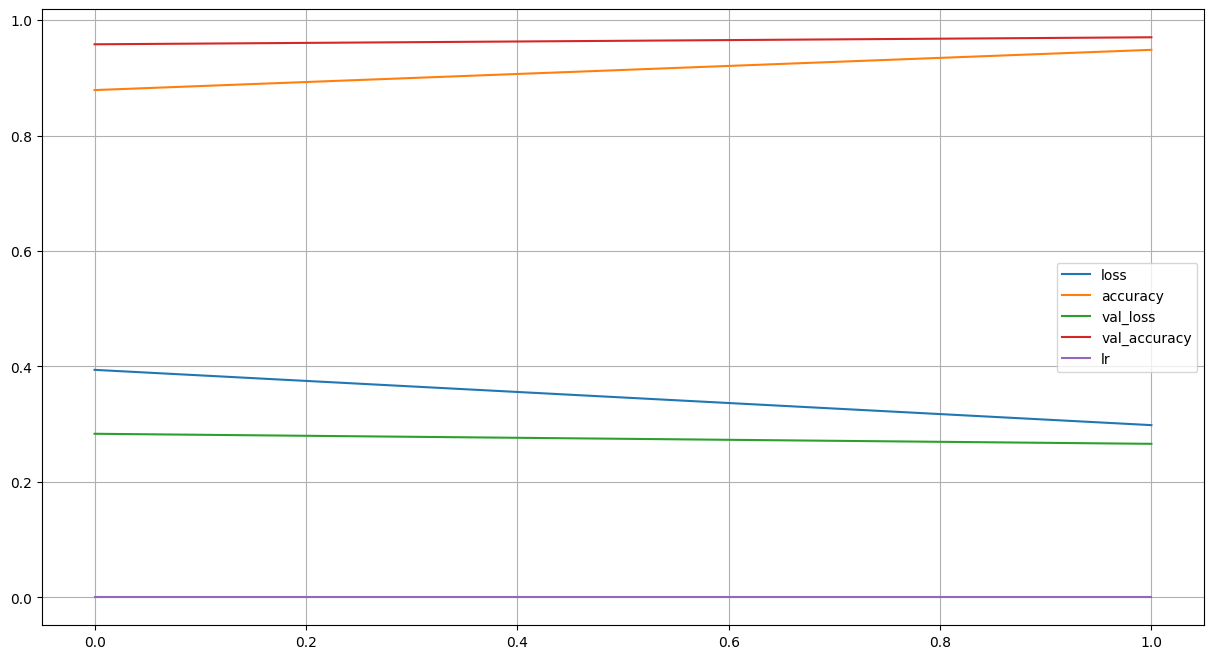

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(15,8))
plt.grid(True)
plt.gca()
plt.show()

In [ ]:
classes =  "dog, cat"

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np


class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confusion Matrix and Classification Report
y_pred=model.predict(test_generator,steps=test_generator.n/batch_size,verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))


print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_true, y_pred, target_names= classes))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

5/5 [==============================] - 1s 101ms/step
Confusion Matrix
[[41  0]
 [ 0 41]]
Classification Report
              precision    recall  f1-score   support

        cats       1.00      1.00      1.00        41
        dogs       1.00      1.00      1.00        41

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82



<Figure size 800x800 with 0 Axes>

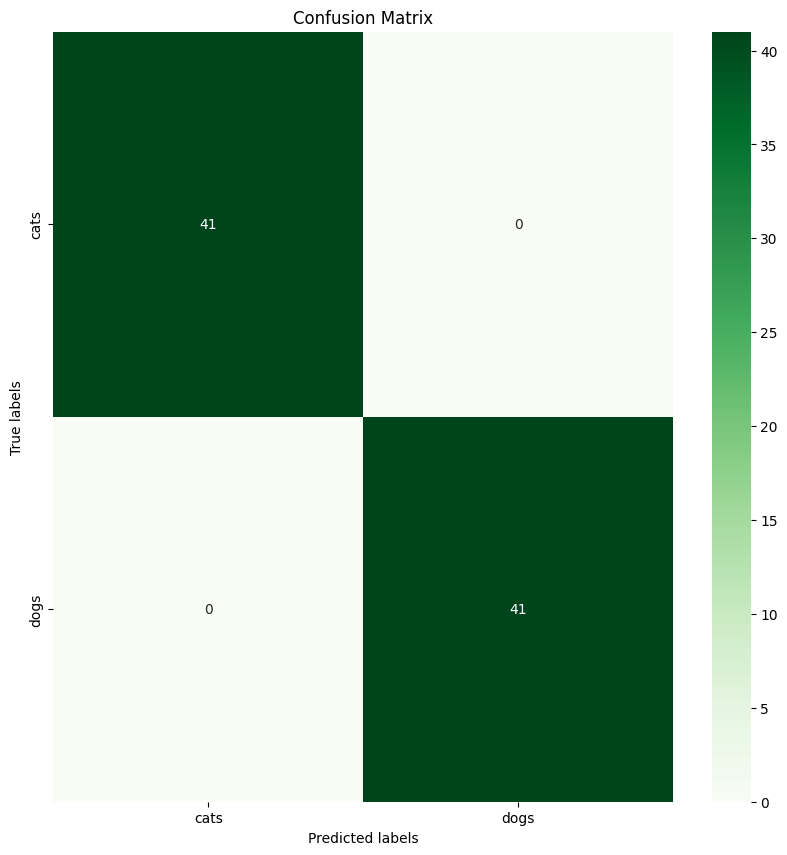

In [ ]:
import seaborn as sb

# ax = plt.figure(figsize=(8, 6))
fig = sb.heatmap(cnf_matrix, annot=True, fmt='g', cmap='Greens')  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
fig.set_xlabel('Predicted labels')
fig.set_ylabel('True labels')
fig.set_title('Confusion Matrix')
fig.xaxis.set_ticklabels(classes)
fig.yaxis.set_ticklabels(classes)
fig.figure.set_size_inches(10, 10)


plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print("\nAccuracy: {:.4f}".format(accuracy))


Accuracy: 1.0000


In [ ]:
from sklearn.metrics import classification_report

# Assuming y_test holds the true labels and y_classes holds the predicted labels
# Calculate classification report
report_dict = classification_report(y_true, y_pred, output_dict=True)

# Now, you can access the average values
macro_precision = report_dict['macro avg']['precision']
macro_recall = report_dict['macro avg']['recall']
macro_f1 = report_dict['macro avg']['f1-score']

weighted_precision = report_dict['weighted avg']['precision']
weighted_recall = report_dict['weighted avg']['recall']
weighted_f1 = report_dict['weighted avg']['f1-score']


# Print out the averages
print(f"Macro Average Precision: {macro_precision:.4f}")
print(f"Macro Average Recall: {macro_recall:.4f}")
print(f"Macro Average F1-score: {macro_f1:.4f}\n")

print(f"Weighted Average Precision: {weighted_precision:.4f}")
print(f"Weighted Average Recall: {weighted_recall:.4f}")
print(f"Weighted Average F1-score: {weighted_f1:.4f}\n")

Macro Average Precision: 1.0000
Macro Average Recall: 1.0000
Macro Average F1-score: 1.0000

Weighted Average Precision: 1.0000
Weighted Average Recall: 1.0000
Weighted Average F1-score: 1.0000

